# KHOA HỌC WEB - PROJECT 2

#### MỐI QUAN HỆ CỦA DỮ LIỆU

#### *Thành viên nhóm*
- 20424027 - Phạm Thị Minh Hậu
- 20424056 - Nguyễn Thế Ngọc
- 20424058 - Nguyễn Văn Nhật

#### *các phần có trong file notebook của nhóm:*
1. Tiền xử lý dữ liệu
2. Thống kê dữ liệu, Chọn lựa trực quan các trường & mối quan hệ giữa chúng

In [1]:
# import các thư viện cần dùng

import numpy as np
import pandas as pd
import lib
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import gaussian_kde
import collections

In [2]:
# Các hàm hỗ trợ
# lấy danh sách sản phẩm theo tên và cấp danh mục
def getProductListByCategory(category_level, category_name, data_arr):
    rs = []
    i=0

    for product in data_arr:
        if product["number"] == category_dict[1][category_name]['arr'][i]:
            rs.append(product)
            i+=1
            if i == category_dict[category_level][category_name]['count']:
                return rs
    return rs

#lấy mảng số lượng đánh giá của 1 danh sách sản phẩm
def getPointCountByProductArr(product_arr):
    rs = [0,0,0,0,0,0]
    for product in product_arr:
        cur_point = int(product["point"])
        if cur_point == 0:
            rs[0]+=1
        else:
            rs[cur_point]+=1
    return rs

### 1. Tiền xử lý dữ liệu

In [3]:
# tiền xử lý dữ liệu từ các file đã lấy được từ project 1 rồi gộp dữ liệu vào 1 file data.json
lib.filterData()

In [4]:
# cách 1: viết lại dữ liệu, bổ sung các trường số bị thiếu = trung bình nếu có thể
lib.rewriteOutliner()

# Cách 2: loại bỏ các dữ liệu rác hoặc dữ liệu không cần thiết
lib.deleteOutliner()

In [5]:
# đọc dữ liệu sau khi tiền xử lý loại bỏ dữ liệu rác dữ liệu thiếu (giá, % giảm, ...)

data = lib.read_json("filtered/data.json")
data_arr = data["data"]

### 2. Thống kê dữ liệu

In [6]:
# tạo các nơi chứa để thống kê về dữ liệu, chứa các id sản phẩm để dễ truy cập

# chỉ về danh mục cấp cao, cấp thấp của sản phẩm
category_dict = {1:{}, 2:{}, 3:{}, 4:{}, 5:{}, 6:{}, 7:{}, 9:{}, 10:{}, "err":{"count":0, "arr":[]}}
# danh mục cha và con xuất hiện cùng lúc
# category_tup = {}

# nền tảng
platform_dict = {}

# mall
mall_dict = { 1:{"count": 0, "arr": []}, 0:{"count": 0, "arr": []} }

# shipping
ship_dict = {}

# giảm giá
discount_dict = {}

# giá gốc
price_dict = {}

# điểm đánh giá
point_dict = {}

# đã bán bao nhiêu sản phẩm
sold_dict = {}

In [7]:
# hàm đếm
def startCountData():
    for product in data_arr:
        # danh mục
        category_level = len(product["category"])
        if category_level == 0:
            category_dict["err"]["count"] += 1
            category_dict["err"]["arr"].append(product["number"])
        else:
            for level in range(1, category_level+1, +1):
                if product["category"][level - 1] not in category_dict[level]:           
                    category_dict[level][product["category"][level - 1]] = {}
                    category_dict[level][product["category"][level - 1]]["count"] = 1
                    category_dict[level][product["category"][level - 1]]["arr"] = [product["number"]]
                else:
                    category_dict[level][product["category"][level - 1]]["count"] += 1
                    category_dict[level][product["category"][level - 1]]["arr"].append(product["number"])
        
        # số sản phẩm đã bán ra
        if product["sold_count"] not in sold_dict:
            sold_dict[product["sold_count"]] = {}
            sold_dict[product["sold_count"]]["count"] = 1
            sold_dict[product["sold_count"]]["arr"] = [product["number"]]
        else:
            sold_dict[product["sold_count"]]["count"] += 1
            sold_dict[product["sold_count"]]["arr"].append(product["number"])
        
        # vietnam/oversea/không xác định
        if product["ship"] not in ship_dict:
            ship_dict[product["ship"]] = {}
            ship_dict[product["ship"]]["count"] = 1
            ship_dict[product["ship"]]["arr"] = [product["number"]]
        else:
            ship_dict[product["ship"]]["count"] += 1
            ship_dict[product["ship"]]["arr"].append(product["number"])

        # nền tảng
        if product["platform"] not in platform_dict:
            platform_dict[product["platform"]] = {}
            platform_dict[product["platform"]]["count"] = 1
            platform_dict[product["platform"]]["arr"] = [product["number"]]
        else:
            platform_dict[product["platform"]]["count"] += 1
            platform_dict[product["platform"]]["arr"].append(product["number"])

        # điểm đánh giá
        if product["point"] not in point_dict:
            point_dict[product["point"]] = {}
            point_dict[product["point"]]["count"] = 1
            point_dict[product["point"]]["arr"] = [product["number"]]
        else:
            point_dict[product["point"]]["count"] += 1
            point_dict[product["point"]]["arr"].append(product["number"])

        # % giảm giá
        if product["discount_percent"] not in discount_dict:
            discount_dict[product["discount_percent"]] = {}
            discount_dict[product["discount_percent"]]["count"] = 1
            discount_dict[product["discount_percent"]]["arr"] = [product["number"]]
        else:
            discount_dict[product["discount_percent"]]["count"] += 1
            discount_dict[product["discount_percent"]]["arr"].append(product["number"])

        # giá gốc
        if product["price"] not in price_dict:
            price_dict[product["price"]] = {}
            price_dict[product["price"]]["count"] = 1
            price_dict[product["price"]]["arr"] = [product["number"]]
        else:
            price_dict[product["price"]]["count"] += 1
            price_dict[product["price"]]["arr"].append(product["number"])

        # mall hay không
        if product["mall"]:
            mall_dict[1]["count"] += 1
            mall_dict[1]["arr"].append(product["number"])
        else:
            mall_dict[0]["count"] += 1
            mall_dict[0]["arr"].append(product["number"])

In [8]:
# chạy đếm để thống kê
startCountData()

#### 2.1 Một số thống kê cơ bản trước khi thống kê chi tiết và vẽ biểu đồ

**Thống kê về các nền tảng mà nhóm thu thập**

In [9]:
# số dữ liệu thu thập dựa trên các nền tảng web
platform_stat = []
for key in platform_dict:
    platform_stat.append([key, platform_dict[key]["count"], 100*platform_dict[key]["count"]/data["count"]])
    
print(tabulate(platform_stat, headers=["Tên nền tảng", "Số sản phẩm", "chiếm %"]))
print("_________________Sản phẩm___________________")
print("mean của data này:", np.mean([i[1] for i in platform_stat]))
print("độ lệch chuẩn(std):", np.std([i[1] for i in platform_stat]))
print("max:", max(i[1] for i in platform_stat))
print("min:", min(i[1] for i in platform_stat))

Tên nền tảng      Số sản phẩm    chiếm %
--------------  -------------  ---------
tiki                     1056    64.4295
shopee                    582    35.5095
_________________Sản phẩm___________________
mean của data này: 819.0
độ lệch chuẩn(std): 237.0
max: 1056
min: 582


**Thống kê về tỷ lệ cửa hàng là mall mà nhóm thu thập**

In [10]:
mall_stat = []
for key in mall_dict:
    mall_stat.append([key, mall_dict[key]["count"], 100*mall_dict[key]["count"]/data["count"]])

print(tabulate(mall_stat, headers=["Có phải mall", "Số sản phẩm", "chiếm %"]))
print("____________________Sản phẩm_____________________")
print("mean của data này:", np.mean([i[1] for i in mall_stat]))
print("độ lệch chuẩn(std):", np.std([i[1] for i in mall_stat]))
print("max:", max(i[1] for i in mall_stat))
print("min:", min(i[1] for i in mall_stat))

  Có phải mall    Số sản phẩm    chiếm %
--------------  -------------  ---------
             1            927    56.5589
             0            711    43.3801
____________________Sản phẩm_____________________
mean của data này: 819.0
độ lệch chuẩn(std): 108.0
max: 927
min: 711


**Thống kê về tỷ lệ cửa hàng trong/ngoài nước**

In [11]:
ship_stat = []

for key in ship_dict:
    ship_stat.append([key, ship_dict[key]["count"], 100*ship_dict[key]["count"]/data["count"]])

print(tabulate(ship_stat, headers=["Cửa hàng tại", "Số sản phẩm", "chiếm %"]))
print("____________________Sản phẩm_____________________")
print("mean của data này:", np.mean([i[1] for i in ship_stat]))
print("độ lệch chuẩn(std):", np.std([i[1] for i in ship_stat]))
print("max:", max(i[1] for i in ship_stat))
print("min:", min(i[1] for i in ship_stat))

Cửa hàng tại      Số sản phẩm    chiếm %
--------------  -------------  ---------
oversea                   608    37.0958
vietnam                  1030    62.8432
____________________Sản phẩm_____________________
mean của data này: 819.0
độ lệch chuẩn(std): 211.0
max: 1030
min: 608


**Thống kê về tỷ lệ đánh giá trên toàn bộ sản phẩm**

In [12]:
point_stat = [["0.0~0.9", 0, 0.0], ["1.0~1.9", 0, 0.0], ["2.0~2.9", 0, 0.0], ["3.0~3.9", 0, 0.0], ["4.0~4.9", 0, 0.0], ["5.0", 0, 0.0]]
point_count = []
for point in point_dict:
    point_count.extend([point]*point_dict[point]["count"])
    cur_point = int(point)
    if cur_point == 0:
        point_stat[0][1] += point_dict[point]["count"]
        point_stat[0][2] = 100*point_stat[0][1]/data["count"]
    elif cur_point == 1:
        point_stat[1][1] += point_dict[point]["count"]
        point_stat[1][2] = 100*point_stat[1][1]/data["count"]
    elif cur_point == 2:
        point_stat[2][1] += point_dict[point]["count"]
        point_stat[2][2] = 100*point_stat[2][1]/data["count"]
    elif cur_point == 3:
        point_stat[3][1] += point_dict[point]["count"]
        point_stat[3][2] = 100*point_stat[3][1]/data["count"]
    elif cur_point == 4:
        point_stat[4][1] += point_dict[point]["count"]
        point_stat[4][2] = 100*point_stat[4][1]/data["count"]
    elif cur_point == 5:
        point_stat[5][1] += point_dict[point]["count"]
        point_stat[5][2] = 100*point_stat[5][1]/data["count"]
        
print(tabulate(point_stat, headers=["điểm đánh giá (0~5 điểm)", "Số sản phẩm", "chiếm %"]))
print("_________________Sản phẩm____________________")
print("mean của data này:", np.mean([i[1] for i in point_stat]))
print("độ lệch chuẩn(std):", np.std([i[1] for i in point_stat]))
print("max:", max(i[1] for i in point_stat))
print("min:", min(i[1] for i in point_stat))
print("_________________Điểm đánh giá______________________")
print("mean của data này:", np.mean(point_count))
print("độ lệch chuẩn(std):", np.std(point_count))
print("max:", max(point_count))
print("min:", min( point_count))

điểm đánh giá (0~5 điểm)      Số sản phẩm    chiếm %
--------------------------  -------------  ---------
0.0~0.9                                 0   0
1.0~1.9                                 5   0.305064
2.0~2.9                                 5   0.305064
3.0~3.9                                64   3.90482
4.0~4.9                              1126  68.7004
5.0                                   438  26.7236
_________________Sản phẩm____________________
mean của data này: 273.0
độ lệch chuẩn(std): 411.6414297257586
max: 1126
min: 0
_________________Điểm đánh giá______________________
mean của data này: 4.676434676434677
độ lệch chuẩn(std): 0.4200197525083536
max: 5.0
min: 1.0


**Thống kê về Cấp độ danh mục (1 > 2 > 3 ...)**

In [13]:
category_level_stat = [["KHÔNG DANH MỤC", category_dict["err"]["count"], 100*category_dict["err"]["count"]/data["count"]]]
for level in category_dict:
    if category_dict[level] != {} and level != "err":
        cur_level = [level, 0, 0]
        for cate in category_dict[level]:
            cur_level[1] += category_dict[level][cate]["count"]
        cur_level[2] = 100*cur_level[1]/data["count"]
        category_level_stat.append(cur_level)

print(tabulate(category_level_stat, headers=["Cấp độ danh mục", "Số sản phẩm", "chiếm %"]))
print("____________________Sản phẩm_____________________")
print("mean của data này:", np.mean([i[1] for i in category_level_stat]))
print("độ lệch chuẩn(std):", np.std([i[1] for i in category_level_stat]))
print("max:", max(i[1] for i in category_level_stat))
print("min:", min(i[1] for i in category_level_stat))

Cấp độ danh mục      Số sản phẩm    chiếm %
-----------------  -------------  ---------
KHÔNG DANH MỤC                 0    0
1                           1638   99.939
2                           1638   99.939
3                           1403   85.601
4                            542   33.0689
5                             42    2.56254
____________________Sản phẩm_____________________
mean của data này: 877.1666666666666
độ lệch chuẩn(std): 708.695613237603
max: 1638
min: 0


**Thống kê về các danh mục là danh mục cấp lớn nhất**

In [14]:
category_highest_stat = []
category_highest_stt = 1
for cate in category_dict[1]:
    category_highest_stat.append([category_highest_stt, cate, category_dict[1][cate]["count"], 100 * category_dict[1][cate]["count"] / 3536])
    category_highest_stt += 1
    
print(tabulate(category_highest_stat, headers=["STT", "Tên danh mục", "Số sản phẩm", "chiếm % (tính trong cấp độ này)"]))

print("___________________Sản phẩm______________________")
print("mean của data này:", np.mean([i[2] for i in category_highest_stat]))
print("độ lệch chuẩn(std):", np.std([i[2] for i in category_highest_stat]))
print("max:", max(i[2] for i in category_highest_stat))
print("min:", min(i[2] for i in category_highest_stat))

  STT  Tên danh mục                           Số sản phẩm    chiếm % (tính trong cấp độ này)
-----  -----------------------------------  -------------  ---------------------------------
    1  Làm Đẹp - Sức Khỏe                             129                          3.64819
    2  Máy Ảnh - Máy Quay Phim                          5                          0.141403
    3  Nhà Cửa - Đời Sống                             186                          5.26018
    4  Thiết Bị Số - Phụ Kiện Số                       87                          2.46041
    5  Điện Gia Dụng                                  201                          5.68439
    6  Túi thời trang nữ                                5                          0.141403
    7  Bách Hóa Online                                 71                          2.00792
    8  Điện Tử - Điện Lạnh                             79                          2.23416
    9  Nhà Sách Tiki                                   44                          1

**Thống kê về giá gốc của toàn bộ sản phẩm**

Vì giá rất nhiều mức, nếu chia khoảng giá (giống điểm đánh giá) sẽ bị mất vài sản phẩm siêu mắc, nên chỉ thống kê cơ bản

In [15]:
price_count = []
for price in price_dict:
    price_count.extend([price]*price_dict[price]["count"])
    
print("_________________Giá gốc______________________")
print("mean của data này:", np.mean(price_count))
print("độ lệch chuẩn(std):", np.std(price_count))
print("max:", max(price_count))
print("min:", min(price_count))

_________________Giá gốc______________________
mean của data này: 1206246.2905982905
độ lệch chuẩn(std): 2916087.267568537
max: 33400000
min: 1800


**Thống kê về số lượng đã bán ra của toàn bộ sản phẩm**

In [16]:
sold_count = []
for sold in sold_dict:
    sold_count.extend([sold]*sold_dict[sold]["count"])
    
print("_________________Số bán ra______________________")
print("mean của data này:", np.mean(sold_count))
print("độ lệch chuẩn(std):", np.std(sold_count))
print("max:", max(sold_count))
print("min:", min(sold_count))

_________________Số bán ra______________________
mean của data này: 2018.694139194139
độ lệch chuẩn(std): 9220.079212768263
max: 196700
min: 0


**Thống kê về % giảm giá (0~100) toàn bộ sản phẩm**

In [17]:
discount_count = []
for discount in discount_dict:
    discount_count.extend([discount]*discount_dict[discount]["count"])

print("_________________% giảm giá______________________")
print("mean của data này:", np.mean(discount_count))
print("độ lệch chuẩn(std):", np.std(discount_count))
print("max:", max(discount_count))
print("min:", min(discount_count))

_________________% giảm giá______________________
mean của data này: 34.77106227106227
độ lệch chuẩn(std): 21.70184729553817
max: 99
min: 0


**Thống kê về giá gốc của danh mục cấp 1 tên là "Điện gia dụng" có 201 sản phẩm**

In [18]:
# danh sách id các sp trog danh mục này
DGD_product = getProductListByCategory(1, 'Điện Gia Dụng', data_arr)

print("_________________Giá gốc 'Điện Gia Dụng'______________________")
print("mean của data này:", np.mean([i["price"] for i in DGD_product]))
print("độ lệch chuẩn(std):", np.std([i["price"] for i in DGD_product]))
print("max:", max([i["price"] for i in DGD_product]))
print("min:", min([i["price"] for i in DGD_product]))

_________________Giá gốc 'Điện Gia Dụng'______________________
mean của data này: 2780506.5621890547
độ lệch chuẩn(std): 3741818.7757000765
max: 33400000
min: 139000


#### 2.1 Thống kê chi tiết, vẽ biểu đồ

**Tần suất xuất hiện các cấp danh mục**

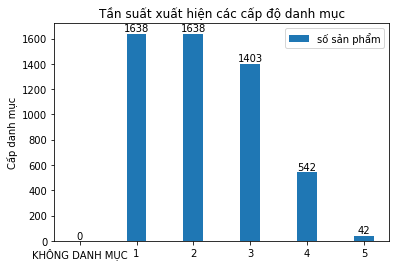

In [19]:
labels = [str(label[0]) for label in category_level_stat]
values = [item[1] for item in category_level_stat]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects = ax.bar(x, values, width, label='số sản phẩm')
ax.set_ylabel('Số sản phẩm')
ax.set_ylabel('Cấp danh mục')
ax.set_title('Tần suất xuất hiện các cấp độ danh mục')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.bar_label(rects, padding=0)

#fig.tight_layout()
plt.show()

**Tần suất điểm đánh giá trên toàn bộ sản phẩm**

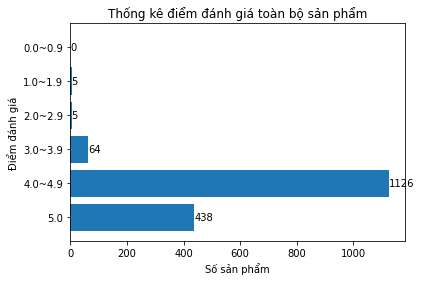

In [20]:
labels = [str(label[0]) for label in point_stat]
values = [item[1] for item in point_stat]
x = np.arange(len(values))
width = 0.35

fig, ax = plt.subplots()
ax.barh(x, values)
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Số sản phẩm')
ax.set_ylabel('Điểm đánh giá')
ax.set_title('Thống kê điểm đánh giá toàn bộ sản phẩm')
ax.bar_label(ax.containers[0])

plt.show()

**Thống kê đánh giá của danh 2 danh mục 'Đồ gia Dụng' và 'Nhà Cửa - Đời Sống'**

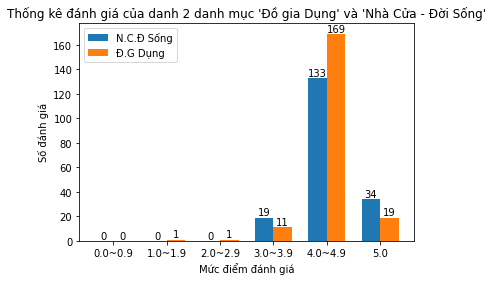

In [21]:
NCDS_product = getProductListByCategory(1, 'Nhà Cửa - Đời Sống', data_arr)
NCDS_point_stat = getPointCountByProductArr(NCDS_product)
DGD_point_stat = getPointCountByProductArr(DGD_product)

x = np.arange(len(labels))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, NCDS_point_stat, width, label='N.C.Đ Sống')
rects2 = ax.bar(x + width/2, DGD_point_stat, width, label='Đ.G Dụng')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=0)
ax.bar_label(rects2, padding=0)

ax.set_xlabel('Mức điểm đánh giá')
ax.set_ylabel('Số đánh giá')
ax.set_title("Thống kê đánh giá của danh 2 danh mục 'Đồ gia Dụng' và 'Nhà Cửa - Đời Sống'")

plt.show()

**Thống kê Quan hệ giữa % giảm giá và số sản phẩm bán được của toàn bộ sản phẩm**

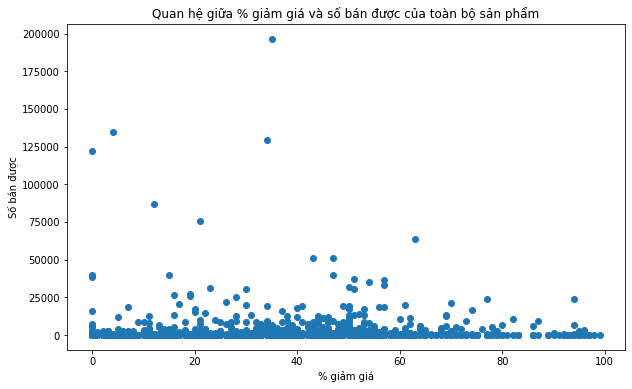

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = [i['discount_percent'] for i in data_arr], y = [i['sold_count'] for i in data_arr])
plt.xlabel("% giảm giá")
plt.ylabel("Số bán được")
ax.set_title("Quan hệ giữa % giảm giá và số bán được của toàn bộ sản phẩm")

plt.show()

**Thống kê Quan hệ giữa % giảm giá và số sản phẩm bán được của danh mục Nhà cửa đời sống**

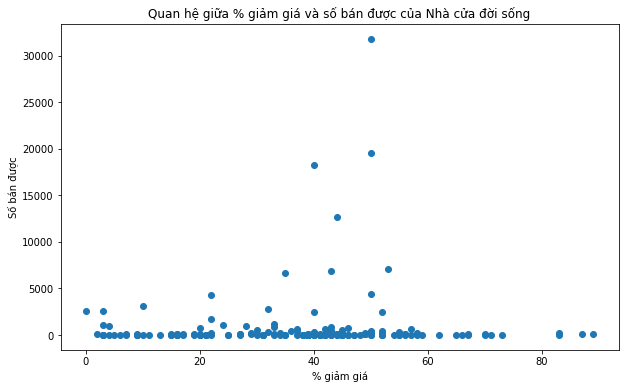

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = [i['discount_percent'] for i in NCDS_product], y = [i['sold_count'] for i in NCDS_product])
plt.xlabel("% giảm giá")
plt.ylabel("Số bán được")
ax.set_title("Quan hệ giữa % giảm giá và số bán được của Nhà cửa đời sống")

plt.show()

**Thống kê Quan hệ giữa % giảm giá và điểm đánh giá sản phẩm**

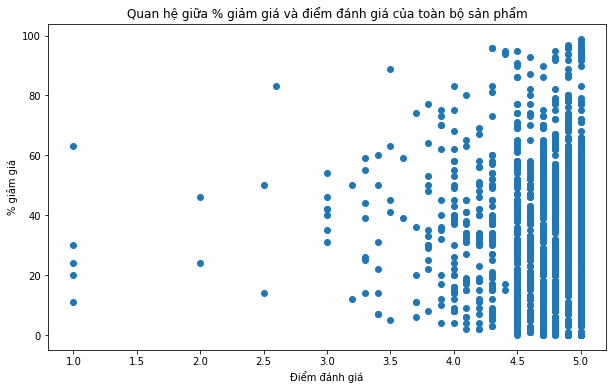

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = [i['point'] for i in data_arr], y = [i['discount_percent'] for i in data_arr])
plt.xlabel("Điểm đánh giá")
plt.ylabel("% giảm giá")
ax.set_title("Quan hệ giữa % giảm giá và điểm đánh giá của toàn bộ sản phẩm")

plt.show()

**Thống kê Quan hệ giữa điểm đánh giá và số bán được**

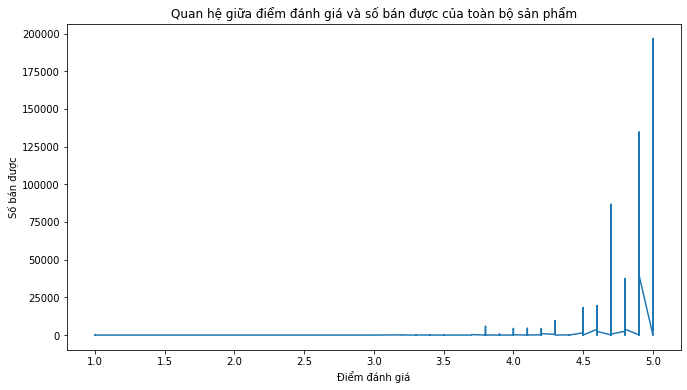

In [25]:
fig, ax = plt.subplots(figsize=(11, 6))
data_arr_by_point = sorted(data_arr, key=lambda d: d['point']) 
# ax.scatter(x = [i['point'] for i in data_arr_by_point], y = [i['sold_count'] for i in data_arr_by_point])
plt.plot([i['point'] for i in data_arr_by_point], [i['sold_count'] for i in data_arr_by_point])
plt.xlabel("Điểm đánh giá")
plt.ylabel("Số bán được")
ax.set_title("Quan hệ giữa điểm đánh giá và số bán được của toàn bộ sản phẩm")
plt.show()

**Thống kê Quan hệ giữa bộ 3: đánh giá, số bán được, %giảm(độ to)**

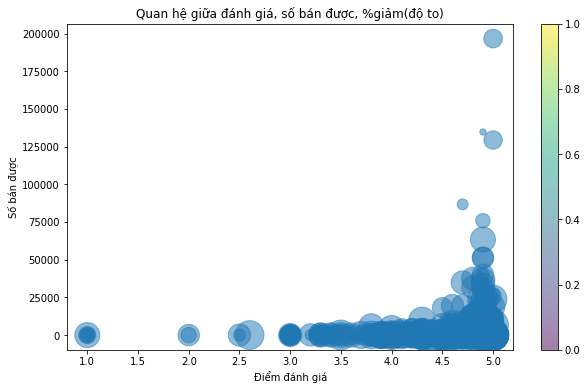

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
z = np.array([i['discount_percent'] for i in data_arr])
colors = np.random.rand(len(z))

plt.scatter(x = [i['point'] for i in data_arr], y = [i['sold_count'] for i in data_arr], s=z*10, alpha=0.5)

plt.xlabel("Điểm đánh giá")
plt.ylabel("Số bán được")
ax.set_title("Quan hệ giữa đánh giá, số bán được, %giảm(độ to)")

plt.colorbar()
plt.show()

**Thống kê số đánh giá của 7 danh mục có số sản phẩm nhiều**

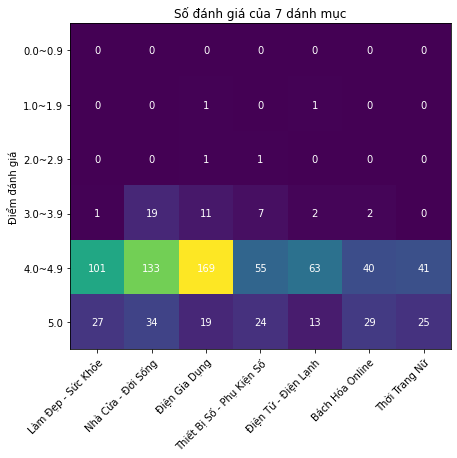

In [27]:
LDSK_product = getProductListByCategory(1, 'Làm Đẹp - Sức Khỏe', data_arr)
TBSPKS_product = getProductListByCategory(1, 'Thiết Bị Số - Phụ Kiện Số', data_arr)
DTDL_product = getProductListByCategory(1, 'Điện Tử - Điện Lạnh', data_arr)
BHO_product = getProductListByCategory(1, 'Bách Hóa Online', data_arr)
TTN_product = getProductListByCategory(1, 'Thời Trang Nữ', data_arr)

LDSK_point_stat = getPointCountByProductArr(LDSK_product)
TBSPKS_point_stat = getPointCountByProductArr(TBSPKS_product)
DTDL_point_stat = getPointCountByProductArr(DTDL_product)
BHO_point_stat = getPointCountByProductArr(BHO_product)
TTN_point_stat = getPointCountByProductArr(TTN_product)

top_category = ["Làm Đẹp - Sức Khỏe",
                "Nhà Cửa - Đời Sống",
                "Điện Gia Dụng",
                "Thiết Bị Số - Phụ Kiện Số",
                "Điện Tử - Điện Lạnh",
                "Bách Hóa Online",
               "Thời Trang Nữ"]

point_matrix = np.array([LDSK_point_stat,
                    NCDS_point_stat,
                    DGD_point_stat,
                    TBSPKS_point_stat,
                    DTDL_point_stat,
                    BHO_point_stat,
                    TTN_point_stat])

point_matrix = point_matrix.T # đổi dòng thành cột, cột thành dòng

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(point_matrix)

ax.set_xticks(np.arange(len(top_category)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(top_category)
ax.set_yticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(labels)):
    for j in range(len(top_category)):
        text = ax.text(j, i, point_matrix[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Số đánh giá của 7 dánh mục")
plt.ylabel("Điểm đánh giá")
plt.show()

**Tỷ lệ các nền tảng của toàn bộ sản phẩm**

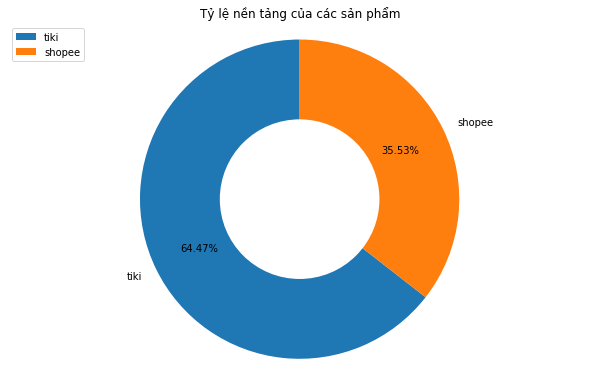

In [28]:
labels = [i[0] for i in platform_stat]
sizes = [i[2] for i in platform_stat]
explode = (0, 0.01)

fig1, ax1 = plt.subplots()
fig1.set_size_inches(10.5, 6.5, forward=True)
ax1.pie(sizes, pctdistance=0.7, labels=labels, autopct='%1.2f%%',
        shadow=False, startangle=90)

centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()

fig.gca().add_artist(centre_circle)
ax1.axis('equal') 
plt.legend(loc='upper left')
plt.title("Tỷ lệ nền tảng của các sản phẩm")
plt.show()

**Tỷ lệ các sản phẩm thuộc về cửa hàng mall**

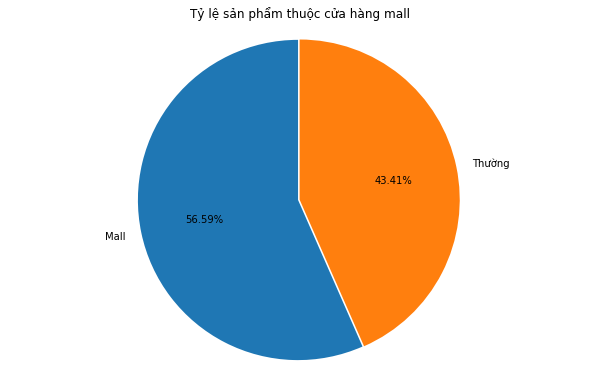

In [29]:
labels = ["Mall", "Thường"]
sizes = [i[2] for i in mall_stat]
explode = (0, 0.01)
fig1, ax1 = plt.subplots()
fig1.set_size_inches(10.5, 6.5, forward=True)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=False, startangle=90)
ax1.axis('equal') 
#plt.legend(loc='upper left')
plt.title("Tỷ lệ sản phẩm thuộc cửa hàng mall")
plt.show()

**Tỷ lệ ship từ trong nước/quốc tế của tiki và shopee**

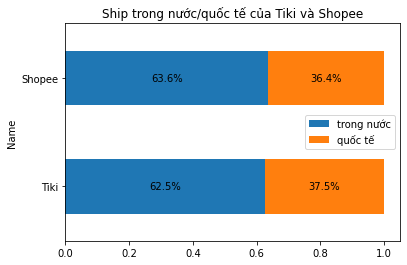

In [30]:
tiki_shopee_option_count = {'tiki': {False:0,True:0,'vietnam':0, 'oversea':0}, 'shopee': {False:0,True:0,'vietnam':0, 'oversea':0}}
for product in data_arr:
    tiki_shopee_option_count[product["platform"]][product["ship"]] +=1
    tiki_shopee_option_count[product["platform"]][product["mall"]] +=1

#print(tiki_shopee_option_count)
for item in tiki_shopee_option_count['tiki']:
    tiki_shopee_option_count['tiki'][item] = tiki_shopee_option_count['tiki'][item]/platform_stat[0][1]
for item in tiki_shopee_option_count['shopee']:
    tiki_shopee_option_count['shopee'][item] = tiki_shopee_option_count['shopee'][item]/platform_stat[1][1]

df = pd.DataFrame({'Name': ['Tiki','Shopee'],'trong nước': 
                   [tiki_shopee_option_count['tiki']['vietnam'],
                    tiki_shopee_option_count['shopee']['vietnam']],
                   'quốc tế':
                   [tiki_shopee_option_count['tiki']['oversea'],
                   tiki_shopee_option_count['shopee']['oversea']]})
#print(df)
df.plot(
    x = 'Name',
    kind = 'barh',
    stacked = True,
    title = 'Ship trong nước/quốc tế của Tiki và Shopee',
    mark_right = True);

df_total = df["trong nước"] + df["quốc tế"] 
df_rel = df[df.columns[1:]].div(df_total, 0)*100
  
for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], 
                                         df[n], df_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                 va = 'center', ha = 'center')

**Tỷ lệ shop mall của tiki và shopee**

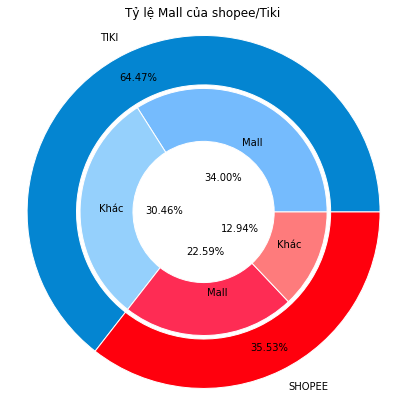

In [31]:
tiki_shopee_option_count = {'tiki': {False:0,True:0,'vietnam':0, 'oversea':0}, 'shopee': {False:0,True:0,'vietnam':0, 'oversea':0}}
for product in data_arr:
    if product["platform"] in tiki_shopee_option_count:
        tiki_shopee_option_count[product["platform"]][product["mall"]] +=1

plt.figure(figsize=(7,7))
plt.pie([platform_stat[0][1], platform_stat[1][1]],
        radius=1, 
        colors=['xkcd:cerulean', 'xkcd:bright red'],
        labels=['TIKI', 'SHOPEE'], autopct='%.2f%%',
        pctdistance=0.85, shadow=False,
        wedgeprops=dict(width=0.28, edgecolor='white'))

plt.pie([tiki_shopee_option_count['tiki'][True],
         tiki_shopee_option_count['tiki'][False],
         tiki_shopee_option_count['shopee'][True],
         tiki_shopee_option_count['shopee'][False]
        ], radius=0.7,
        colors=['xkcd:sky blue', 'xkcd:light blue', 'xkcd:reddish pink',
                'xkcd:salmon pink'],
        wedgeprops=dict(width=0.3, edgecolor='white'),
        labels=['Mall', 'Khác', 'Mall', 'Khác'], autopct='%.2f%%',
        pctdistance=0.32, labeldistance=0.65, shadow=False)
plt.title("Tỷ lệ Mall của shopee/Tiki")
#plt.legend(loc='upper left')
plt.axis('equal')
plt.show()

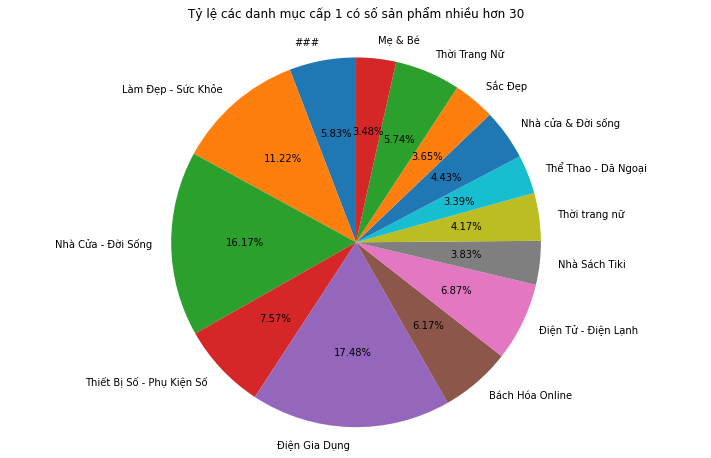

In [32]:
category_highest_stat_greater = [[0,'###', 0]]
for item in category_highest_stat:
    if item[2] > 30:
        category_highest_stat_greater.append(item)
    else:
        category_highest_stat_greater[0][2] +=1
    
labels = [i[1] for i in category_highest_stat_greater]
sizes = [i[2] for i in category_highest_stat_greater]
fig1, ax1 = plt.subplots()
fig1.set_size_inches(12.5, 7.5, forward=True)
ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
        shadow=False, startangle=90)
ax1.axis('equal') 
# plt.legend(loc='upper left')
plt.title("Tỷ lệ các danh mục cấp 1 có số sản phẩm nhiều hơn 30\n")
plt.show()

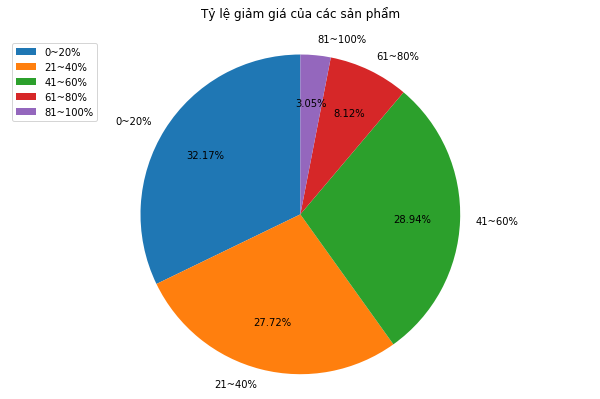

In [33]:
discount_count =[['0~20%', 0], ['21~40%', 0], ['41~60%', 0], ['61~80%', 0], ['81~100%', 0]]
for item in discount_dict:
#     if item < 1:
#         discount_count[0][1] += discount_dict[item]['count']
    if item < 21:
        discount_count[0][1] += discount_dict[item]['count']
    elif item < 41:
        discount_count[1][1] += discount_dict[item]['count']
    elif item < 61:
        discount_count[2][1] += discount_dict[item]['count']
    elif item < 81:
        discount_count[3][1] += discount_dict[item]['count']
    elif item > 80:
        discount_count[4][1] += discount_dict[item]['count']

labels = [i[0] for i in discount_count]
sizes = [i[1] for i in discount_count]
fig1, ax1 = plt.subplots()
fig1.set_size_inches(10.5, 6.5, forward=True)
ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
        shadow=False, startangle=90, pctdistance=0.7, labeldistance=1.1)
ax1.axis('equal') 
plt.legend(loc='upper left')
plt.title("Tỷ lệ giảm giá của các sản phẩm\n")
plt.show()

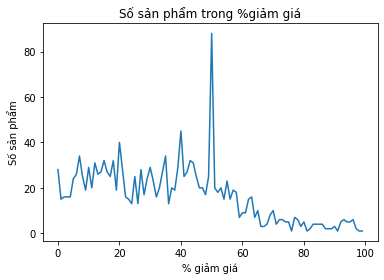

In [34]:
discount_dict_sorted = collections.OrderedDict(sorted(discount_dict.items()))

x = [item for item in discount_dict_sorted]
y = [discount_dict_sorted[item]["count"] for item in discount_dict_sorted]

plt.xlabel("% giảm giá")
plt.ylabel("Số sản phẩm")
plt.title("Số sản phẩm trong %giảm giá")
plt.plot(x, y)
plt.show()

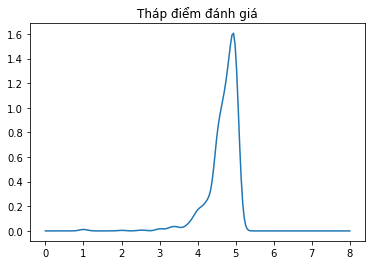

In [35]:
data = [item["point"] for item in data_arr]
density = gaussian_kde(data)
xs = np.linspace(0,8,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.title("Tháp điểm đánh giá");
plt.plot(xs,density(xs))
plt.show()

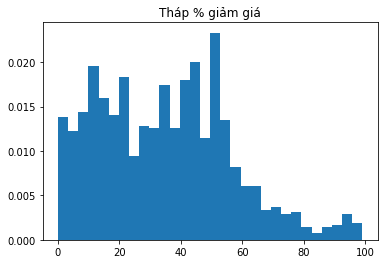

In [36]:
x = [i["discount_percent"] for i in data_arr]
plt.title("Tháp % giảm giá")

plt.hist(x, bins=30, density=True)
plt.show()

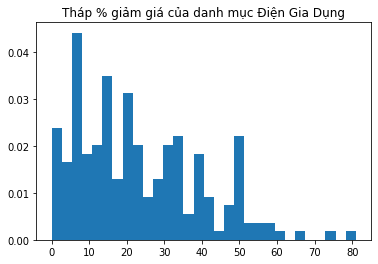

In [37]:
x = [i["discount_percent"] for i in DGD_product]
plt.title("Tháp % giảm giá của danh mục Điện Gia Dụng")

plt.hist(x, bins=30, density=True)
plt.show()

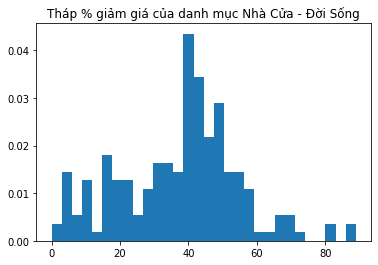

In [38]:
x = [i["discount_percent"] for i in NCDS_product]
plt.title("Tháp % giảm giá của danh mục Nhà Cửa - Đời Sống")

plt.hist(x, bins=30, density=True)
plt.show()

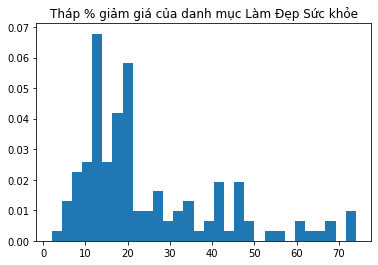

In [39]:
x = [i["discount_percent"] for i in LDSK_product]
plt.title("Tháp % giảm giá của danh mục Làm Đẹp Sức khỏe")

plt.hist(x, bins=30, density=True)
plt.show()

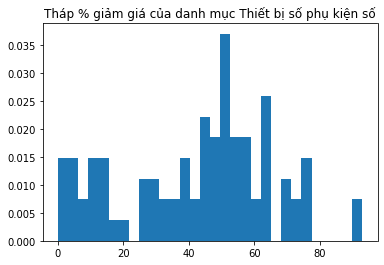

In [40]:
x = [i["discount_percent"] for i in TBSPKS_product]
plt.title("Tháp % giảm giá của danh mục Thiết bị số phụ kiện số")

plt.hist(x, bins=30, density=True)
plt.show()